In [10]:
# Import the necessary components
from epydemix import EpiModel, simulate
from epydemix.visualization import plot_quantiles, plot_trajectories
import matplotlib.pyplot as plt

# Defining a basic SIR model
sir_model = EpiModel(
    name='SIR Model',
    compartments=['S', 'I', 'R'],  # Susceptible, Infected, Recovered
    parameters={
        'beta': 0.3,  # Transmission rate
        'gamma': 0.1  # Recovery rate
    }
)

# Defining the transitions
sir_model.add_transition(source='S', target='I', rate='beta', params={"agent": "I"}, kind='mediated')
sir_model.add_transition(source='I', target='R', rate='gamma', kind='spontaneous')

print(sir_model)

EpiModel(name='SIR Model')
Compartments: 3
  S, I, R
Transitions: 2
  Transitions between compartments:
    S -> I, rate: ['beta'], params: {'agent': 'I'} (kind: mediated)
    I -> R, rate: ['gamma'], params: {} (kind: spontaneous)
Parameters: 2
  Model parameters:
    beta: 0.3
    gamma: 0.1
Population: epydemix_population
  Population size: 100000 individuals
  Demographic groups: 1
    0



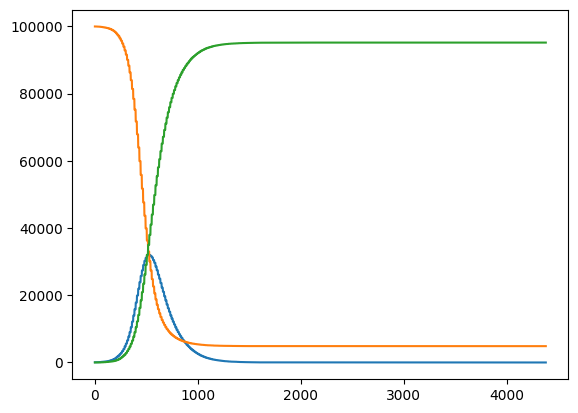

In [13]:
results = simulate(sir_model, resample_frequency="2h")
plt.plot(results.compartments["I_total"])
plt.plot(results.compartments["S_total"])
plt.plot(results.compartments["R_total"])


In [ ]:
# running the simulations
sir_results = sir_model.run_simulations(
    start_date="2024-01-01",
    end_date="2024-04-10",
)

In [ ]:
import matplotlib.pyplot as plt
plt.plot(results.compartments["S_total"])
plt.plot(results.compartments["I_total"])
plt.plot(results.compartments["R_total"])

In [ ]:
sir_model.parameters